# 1D CNN with Laplace Beltrami Spectrum

## Binary Classification: Males vs. Females

Here we are going to see if we can create a 1 dimensional convolutional neural network that can classify a subject as male or female based on the shape (LB spectrum) of their white matter tracts.

The initial set up will be very similar to the MLP as we want the data to remain as a 1D vector. The main changes will be the types of layers in the actual network.

### Import libraries
First, let's import the libraries we will use.

In [2]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import and check the data
Now let's read in the data using pickle. The data was previously processed in python and saved down using pickle. This will be the same steps as used in the MLP notebook so I will not include as many comments

In [3]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
tractev_dict_600 = pickle.load(open("tract_ev_dict_600.pk",'rb'))
# list of tracts we want to use
tractstouse = pickle.load(open('tractstouse.pk','rb'))
# subject list
HCP_subj_list = pickle.load(open('HCP_subj_list.pk','rb'))
# list of subject gender 1 = male, 2 = female
gender_id = pickle.load(open('gender_id.pk','rb'))

### Preprocess the data

The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a single 1D vector per subject. 

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's `StandardScaler` function.

**Normalize the data**

In [4]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict


In [5]:
# normalize all of the tracts so that each ev is centered on 0.
tractev_dict_600_scaled = scale_ev_dict(tractev_dict_600)

**Reorganize the data**

Currently the data is a dictionary of 2D matrices, we want to reorganize this into a single 2D matrix with the shape `(1013, n * 48)`, where 1013 is the number of subjects and n is the number of eigenvalues we are using. This is not the final shape we want for the convolutional layers, but it is the shape we want for now. It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues. 

In [6]:
# change the organization to be one vector per subject with all evs for all tracts
def reorganize_spectrums(ev_dict_scaled, numev, HCP_subj_list=HCP_subj_list, tractstouse=tractstouse):
    # create an empty numpy array of the shape we want
    # numev is the number of eigenvalues we want per tract
    allsubjs_alltracts_scaled = np.zeros([len(HCP_subj_list), numev*len(tractstouse)])
    for i in range(len(tractstouse)):
        allsubjs_alltracts_scaled[:, i*numev:i*numev+numev] = ev_dict_scaled[tractstouse[i]][:, 0:numev]
    return allsubjs_alltracts_scaled

In [7]:
numev=200
allsubjs_alltracts_scaled = reorganize_spectrums(tractev_dict_600_scaled, numev)

**One hot encoding the labels**

To one hot encoding these labels all we need to do is simple subtract 1 from every entry. Now 0 = male and 1 = female

In [8]:
# one-hot encoding for the gender ID
genderid_ohe = np.asarray(gender_id) - 1

**Check datatype**

Finally, we need to make sure all inputs are of datatype `float32`

In [9]:
allsubjs_alltracts_scaled = allsubjs_alltracts_scaled.astype('float32')
genderid_ohe = genderid_ohe.astype('float32')

### Split the data

The input data is now preprocessed and ready to be input into a neural network. However, we first have to split the data into training, validation, and testing sets. We do not have a ton of samples, so we will try splitting the data into 3 subsets first and then explore other cross validation options.

In [10]:
X = allsubjs_alltracts_scaled
Y = genderid_ohe

#first split the training/validation data from the testing data
trainvalX, testX, trainvalY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainvalX) 
print len(testX)

810
203


In [11]:
#second split the validation data from the training data
trainX, valX, trainY, valY = train_test_split(trainvalX, trainvalY, train_size  = .75, test_size = .25, random_state=0)

print len(trainX)
print len(valX)

607
203


Now we have 3 subsets of data. Training data with 607 samples, validation data with 203 samples, and testing data with 203 samples. Again, this may be too few samples for training and if so we can employ other cross validation methods.

### Try Logistic Regression Classifier from sklearn for comparison

One of the reasons we are trying deep learning with this data is to see if we can improve upon 'basic' machine learning algorithms. We have already looked at this with the MLP notebook, but let's run the classification with the logistic regression classifier again as a reminder. We will train and evaluate the training and validation splits as well as the training/val and testing splits. 

In [12]:
#train on training data
lr = LogisticRegressionCV()
lr.fit(trainX, trainY)

#evaluate with validation data
print("Accuracy = {:.2f}".format(lr.score(valX, valY)))

Accuracy = 0.81


In [13]:
#train on training and validation data
lr = LogisticRegressionCV()
lr.fit(trainvalX, trainvalY)

#evaluate with validation data
print("Accuracy = {:.2f}".format(lr.score(testX, testY)))

Accuracy = 0.80


### Set up the 1D CNN

Our goal is to try and train a 1D CNN to get an accuracy value higher than 81% (for validation) or 80% (for final testing). 

As we saw before, we can plot the history of the accuracy and loss as the model trains, let's define that function here.

In [14]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

### Reshape the data for CNN layers

Now we need to change the shape again to be a 3D instead of a 2D array. We need each subject to have their own 2D array. The final shape will be (num subjects, num total eigenvalues, 1). 

If this were a sequence it would be (num samples, num timestamps, num features per timestamp). I find it helps with understanding the shape if you think about the data in terms of timestamps, even though it is not sequential data. 

Another way we could format the data is by splitting each tract into its own feature, rather than combining them all into one. In that case, the shape would be (num subjects, num eigenvalues per tract, num tracts). Each tract is a feature, and each eigenvalue is a timestamp. 

In [15]:
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
print trainX.shape
valX = valX.reshape(valX.shape[0], valX.shape[1], 1)
print valX.shape
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)
print testX.shape

(607, 9600, 1)
(203, 9600, 1)
(203, 9600, 1)


Let's try a simple network architecture from the 1D CNN example from Keras.

Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6442 - val_loss: 0.5807 - val_acc: 0.6847
Epoch 2/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5960 - acc: 0.6969 - val_loss: 0.6018 - val_acc: 0.6404
Epoch 3/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5873 - acc: 0.7068 - val_loss: 0.5357 - val_acc: 0.7340
Epoch 4/20
607/607 [==============================] - 1s 2ms/step - loss: 0.6137 - acc: 0.6540 - val_loss: 0.5645 - val_acc: 0.7094
Epoch 5/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5923 - acc: 0.6722 - val_loss: 0.5597 - val_acc: 0.7044
Epoch 6/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5914 - acc: 0.6903 - val_loss: 0.5344 - val_acc: 0.7438
Epoch 7/20
607/607 [==============================] - 1s 2ms/step - loss: 0.5890 - acc: 0.6985 - val_loss: 0.5449 - val_acc: 0.7488
Epoch 8/20
607/607 [==========

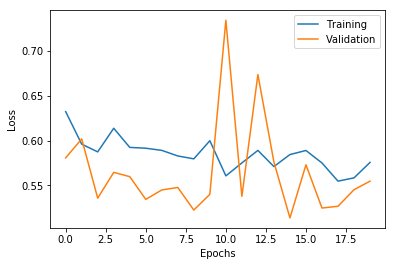

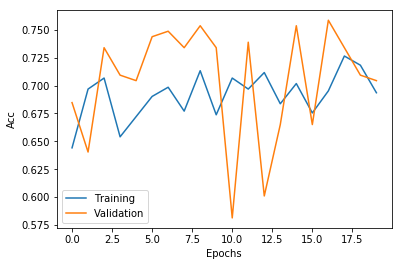

In [15]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=10, validation_data=(valX, valY))

plot_history(history)


The best accuracy was 75%, which is not bad, but we can see some weird behavior around 10 and 12 epochs. The accuracy drops significantly, maybe due to the drop out?

Let's make a function to make and fit the model so we can manually tune some of the parameters.

In [36]:
# hidden_units = 64
# kernel_size = 3
# dropout = .5
# optim = 'adam'
# epochs = 20
# batch = 10

def make_model(hidden_units, kernel_size, dropout, optim, epochs, batch):
    model = Sequential()
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1)))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu'))
    model.add(MaxPooling1D(kernel_size))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu'))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(valX, valY))

    plot_history(history)

Let's try increasing the number of hidden units, reducing dropout, as well as adjusting the learning rate of the optimizer. 

Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 4s 7ms/step - loss: 0.6905 - acc: 0.5997 - val_loss: 0.6894 - val_acc: 0.4975
Epoch 2/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6848 - acc: 0.5667 - val_loss: 0.6853 - val_acc: 0.5074
Epoch 3/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6785 - acc: 0.5717 - val_loss: 0.6807 - val_acc: 0.5074
Epoch 4/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6711 - acc: 0.5832 - val_loss: 0.6753 - val_acc: 0.5222
Epoch 5/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6642 - acc: 0.5750 - val_loss: 0.6696 - val_acc: 0.5222
Epoch 6/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6564 - acc: 0.5799 - val_loss: 0.6630 - val_acc: 0.5517
Epoch 7/40
607/607 [==============================] - 4s 6ms/step - loss: 0.6479 - acc: 0.6063 - val_loss: 0.6526 - val_acc: 0.5961
Epoch 8/40
607/607 [==========

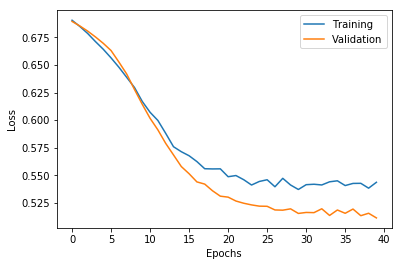

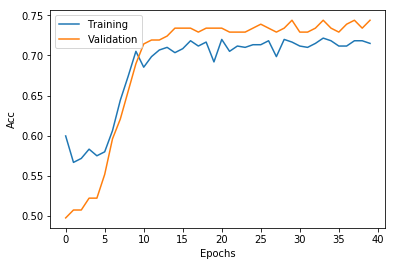

In [18]:
hidden_units = 200
kernel_size = 3
dropout = .1
optim = Adam(lr=0.00001)
epochs = 40
batch = 10
make_model(hidden_units, kernel_size, dropout, optim, epochs, batch)

After trying a few different combinations of paramters, we can't seem to do better than 75%. We may need to change the model architecture. 

Let's also try adding regularization. 

In [16]:
from keras import backend as K
import gc

In [17]:
#sometimes python does not release memory very well on its own, these help clear memory
K.clear_session()
gc.collect()

10

In [18]:
from keras.regularizers import l1, l2, l1_l2

It may be that the global pooling layer is reducing the data too much. Let's try removing that layer. If we do not have a global pooling layer, we need to insert a **Flatten** layer to flatten the convolutional output into a shape the final dense layer can read.

Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 2s 3ms/step - loss: 31.1056 - acc: 0.5651 - val_loss: 29.9435 - val_acc: 0.5862
Epoch 2/40
607/607 [==============================] - 1s 2ms/step - loss: 29.0248 - acc: 0.6557 - val_loss: 28.0210 - val_acc: 0.6798
Epoch 3/40
607/607 [==============================] - 1s 2ms/step - loss: 27.1476 - acc: 0.7199 - val_loss: 26.2018 - val_acc: 0.6798
Epoch 4/40
607/607 [==============================] - 1s 2ms/step - loss: 25.3655 - acc: 0.7512 - val_loss: 24.4291 - val_acc: 0.7882
Epoch 5/40
607/607 [==============================] - 1s 2ms/step - loss: 23.6510 - acc: 0.7776 - val_loss: 22.8032 - val_acc: 0.7340
Epoch 6/40
607/607 [==============================] - 1s 2ms/step - loss: 22.0358 - acc: 0.7710 - val_loss: 21.1986 - val_acc: 0.8030
Epoch 7/40
607/607 [==============================] - 1s 2ms/step - loss: 20.4988 - acc: 0.8072 - val_loss: 19.6915 - val_acc: 0.8128
Epoch 8/40
607/6

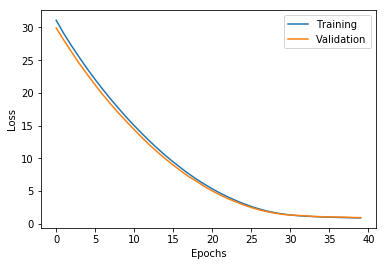

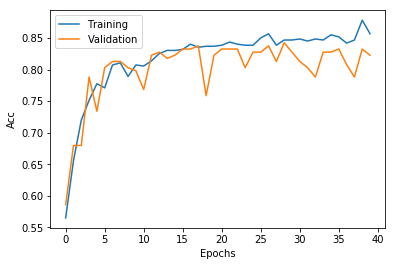

In [21]:
hidden_units = 64
kernel_size = 5
dropout = .7
optim = RMSprop(lr=0.0001)
epochs = 40
batch = 20

model = Sequential()
model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1), kernel_regularizer=l1_l2(.01)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.01)))
model.add(MaxPooling1D(kernel_size))
model.add(Dropout(dropout))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.01)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.01)))
# model.add(GlobalAveragePooling1D())
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(valX, valY))

plot_history(history)

Train on 607 samples, validate on 203 samples
Epoch 1/60
607/607 [==============================] - 4s 7ms/step - loss: 8.0603 - acc: 0.5453 - val_loss: 7.8564 - val_acc: 0.5222
Epoch 2/60
607/607 [==============================] - 2s 3ms/step - loss: 7.6691 - acc: 0.6326 - val_loss: 7.4812 - val_acc: 0.6798
Epoch 3/60
607/607 [==============================] - 2s 3ms/step - loss: 7.2724 - acc: 0.6969 - val_loss: 7.1241 - val_acc: 0.6355
Epoch 4/60
607/607 [==============================] - 2s 3ms/step - loss: 6.8969 - acc: 0.7529 - val_loss: 6.7389 - val_acc: 0.7488
Epoch 5/60
607/607 [==============================] - 2s 3ms/step - loss: 6.5494 - acc: 0.7809 - val_loss: 6.4391 - val_acc: 0.7143
Epoch 6/60
607/607 [==============================] - 2s 3ms/step - loss: 6.2346 - acc: 0.7924 - val_loss: 6.1224 - val_acc: 0.7586
Epoch 7/60
607/607 [==============================] - 2s 3ms/step - loss: 5.9385 - acc: 0.8221 - val_loss: 5.8495 - val_acc: 0.7685
Epoch 8/60
607/607 [==========

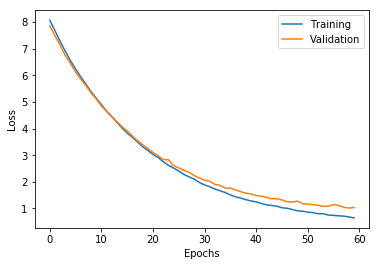

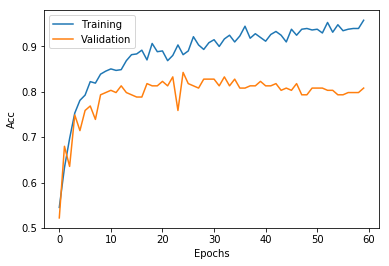

In [55]:
hidden_units = 100
kernel_size = 3
dropout = .8
optim = Adam(lr=0.0001)
epochs = 60
batch = 20

model = Sequential()
model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1), kernel_regularizer=l1_l2(.001)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(MaxPooling1D(kernel_size))
model.add(Dropout(dropout))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(MaxPooling1D(kernel_size))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(valX, valY))

plot_history(history)

The highest accuracy we are getting is 84%. Let's set up a grid search to find the best hyperparameters. 

In [35]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def make_model_compile(hidden_units, kernel_size, dropout, optim, epochs, batch, reg):
    model = Sequential()
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', input_shape=(trainX.shape[1], 1), kernel_regularizer=l1_l2(reg)))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(reg)))
    model.add(MaxPooling1D(kernel_size))
    model.add(Dropout(dropout))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(reg)))
    model.add(Conv1D(hidden_units, kernel_size, activation='relu', kernel_regularizer=l1_l2(reg)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])


In [38]:
my_classifier = KerasClassifier(make_model_compile)

#define the grid search 
validator = GridSearchCV(my_classifier,
                         param_grid={'hidden_units': [32, 64],
                                     'kernel_size': [3,5]
                                     'dropout_prop': [0.3, 0.5, 0.7], 
                                     'optim': [RMSprop(lr=.01), RMSprop(lr=.001), RMSprop(lr=.0001),RMSprop(lr=.00001)], 
                                     'epochs':[10,20,40], 
                                     'batch': [10,15,20],
                                     'reg': [0.01,0.001,0.0001]},
                                    scoring='neg_log_loss')
# validator.fit(trainvalX, trainvalY) 

In [ ]:
print('The parameters of the best model are: ')
print(validator.best_params_)

In [ ]:
# The optimizer is an object, we need to evaluate it
from keras.backend import eval
print eval(validator.best_params_['optim'].lr)

Please continue on to [2D CNN - Gender Classification](https://github.com/kitchell/DeepLearningTutorial_LBspectrum/blob/master/2D%20CNN%20with%20LB%20spectrum.ipynb)
